In [1]:
from enum import IntEnum
from queue import Queue

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
from tqdm import tqdm

from utils import (
    FRAME_PER_SEG, 
    FRAME_RATE, 
    MockAudioStream,
    get_score_features, 
    run_evaluation,
    visualize_warping_path,
)

WINDOW_SIZE = 3  # seconds
DEFAULT_LOCAL_COST = "euclidean"
MAX_RUN_COUNT = 30

In [2]:
class Direction(IntEnum):
    REF = 0
    TARGET = 1
    BOTH = 2

    def toggle(self):
        return Direction(self ^ 1) if self != Direction.BOTH else Direction.TARGET


class OLTW:
    """
    On-line Dynamic Time Warping (OLTW) algorithm for aligning a input sequence to a reference sequence.

    Parameters
    ----------
    reference_features : np.ndarray
        A 2D array with dimensions (`T(n_timesteps)`, `F(n_features)`) containing the
        features of the reference the input is going to be aligned to.

    queue : Queue
        A queue for storing the input features, which shares the same object as the audio stream.

    window_size : int
        Size of the window (in seconds) for searching the optimal path in the cost matrix.

    local_cost_fun : str
        Local metric for computing pairwise distances.

    max_run_count : int
        Maximum number of times the class can run in the same direction.

    frame_per_seg : int
        Number of frames per segment (audio chunk). default is 1.

    frame_rate : int
        Frame rate of the audio stream.

    Attributes
    ----------
    warping_path : np.ndarray [shape=(2, T)]
        Warping path with pairs of indices of the reference and target features.
        where warping_path[0] is the index of the reference feature and warping_path[1] is the index of the target(input) feature.
    """

    def __init__(
        self,
        reference_features,
        queue,
        window_size=WINDOW_SIZE,
        local_cost_fun=DEFAULT_LOCAL_COST,
        max_run_count=MAX_RUN_COUNT,
        frame_per_seg=FRAME_PER_SEG,
        frame_rate=FRAME_RATE,
        **kwargs,
    ):
        self.reference_features = reference_features
        self.N_ref = self.reference_features.shape[0]
        self.input_features = np.empty((0, self.reference_features.shape[1]))
        self.w = int(window_size * frame_rate)
        self.local_cost_fun = local_cost_fun
        self.max_run_count = max_run_count
        self.frame_per_seg = frame_per_seg
        self.current_position = 0
        self.wp = np.array([[0, 0]]).T  # [shape=(2, T)]
        self.queue = queue
        self.ref_pointer = 0
        self.input_pointer = 0
        self.input_index: int = 0
        self.run_count = 0
        self.previous_direction = None

    @property
    def warping_path(self):  # [shape=(2, T)]
        return self.wp

    def offset(self):
        offset_x = max(self.ref_pointer - self.w, 0)
        offset_y = max(self.input_pointer - self.w, 0)
        return np.array([offset_x, offset_y])

    def init_matrix(self):
        x = self.ref_pointer
        y = self.input_pointer
        d = self.frame_per_seg
        wx = min(self.w, x)
        wy = min(self.w, y)
        new_acc = np.zeros((wx, wy))
        new_len_acc = np.zeros((wx, wy))
        x_seg = self.reference_features[x - wx : x]  # [wx, 12]
        y_seg = self.input_features[min(y - d, 0) : y]  # [d, 12]
        dist = scipy.spatial.distance.cdist(
            x_seg, y_seg, metric=self.local_cost_fun
        )  # [wx, d]

        for i in range(wx):
            for j in range(d):
                local_dist = dist[i, j]
                update_x0 = 0
                update_y0 = wy - d
                if i == 0 and j == 0:
                    new_acc[i, j] = local_dist
                elif i == 0:
                    new_acc[i, update_y0 + j] = local_dist + new_acc[i, update_y0 - 1]
                    new_len_acc[i, update_y0 + j] = 1 + new_len_acc[i, update_y0 - 1]
                elif j == 0:
                    new_acc[i, update_y0 + j] = local_dist + new_acc[i - 1, update_y0]
                    new_len_acc[i, update_y0 + j] = (
                        local_dist + new_len_acc[i - 1, update_y0]
                    )
        self.acc_dist_matrix = new_acc
        self.acc_len_matrix = new_len_acc
        self.select_candidate()

    def update_ref_direction(self, dist, new_acc, new_len_acc, wx, wy, d):
        for i in range(d):
            for j in range(wy):
                local_dist = dist[i, j]
                update_x0 = wx - d
                update_y0 = 0
                if j == 0:
                    new_acc[update_x0 + i, j] = (
                        local_dist + new_acc[update_x0 + i - 1, j]
                    )
                    new_len_acc[update_x0 + i, j] = (
                        new_len_acc[update_x0 + i - 1, j] + 1
                    )
                else:
                    compares = [
                        new_acc[update_x0 + i - 1, j],
                        new_acc[update_x0 + i, j - 1],
                        new_acc[update_x0 + i - 1, j - 1] * 0.98,
                    ]
                    len_compares = [
                        new_len_acc[update_x0 + i - 1, j],
                        new_len_acc[update_x0 + i, j - 1],
                        new_len_acc[update_x0 + i - 1, j - 1],
                    ]
                    local_direction = np.argmin(compares)
                    new_acc[update_x0 + i, j] = local_dist + compares[local_direction]
                    new_len_acc[update_x0 + i, j] = 1 + len_compares[local_direction]
        return new_acc, new_len_acc

    def update_target_direction(self, dist, new_acc, new_len_acc, wx, wy, d):
        for i in range(wx):
            for j in range(d):
                local_dist = dist[i, j]
                update_x0 = 0
                update_y0 = wy - d
                if i == 0:
                    new_acc[i, update_y0 + j] = local_dist + new_acc[i, update_y0 - 1]
                    new_len_acc[i, update_y0 + j] = 1 + new_len_acc[i, update_y0 - 1]
                else:
                    compares = [
                        new_acc[i - 1, update_y0 + j],
                        new_acc[i, update_y0 + j - 1],
                        new_acc[i - 1, update_y0 + j - 1] * 0.98,
                    ]
                    len_compares = [
                        new_len_acc[i - 1, update_y0 + j],
                        new_len_acc[i, update_y0 + j - 1],
                        new_len_acc[i - 1, update_y0 + j - 1],
                    ]
                    local_direction = np.argmin(compares)
                    new_acc[i, update_y0 + j] = local_dist + compares[local_direction]
                    new_len_acc[i, update_y0 + j] = 1 + len_compares[local_direction]
        return new_acc, new_len_acc

    def update_accumulate_matrix(self, direction):
        # local cost matrix
        x, y = self.ref_pointer, self.input_pointer
        wx, wy = min(self.w, x), min(self.w, y)
        d = self.frame_per_seg
        new_acc = np.full((wx, wy), np.inf, dtype=np.float32)
        new_len_acc = np.zeros((wx, wy))

        if direction is not Direction.TARGET:  # REF, BOTH
            new_acc[:-d, :] = self.acc_dist_matrix[d:]
            new_len_acc[:-d, :] = self.acc_len_matrix[d:]
            x_seg = self.reference_features[x - d : x]  # [d, 12]
            y_seg = self.input_features[y - wy : y]  # [wy, 12]
            dist = scipy.spatial.distance.cdist(
                x_seg, y_seg, metric=self.local_cost_fun
            )  # [d, wy]
            new_acc, new_len_acc = self.update_ref_direction(
                dist, new_acc, new_len_acc, wx, wy, d
            )

        elif direction is not Direction.REF:  # TARGET, BOTH
            overlap_y = wy - d
            new_acc[:, :-d] = self.acc_dist_matrix[:, -overlap_y:]
            new_len_acc[:, :-d] = self.acc_len_matrix[:, -overlap_y:]
            x_seg = self.reference_features[x - wx : x]  # [wx, 12]
            y_seg = self.input_features[y - d : y]  # [d, 12]
            dist = scipy.spatial.distance.cdist(
                x_seg, y_seg, metric=self.local_cost_fun
            )  # [wx, d]
            new_acc, new_len_acc = self.update_target_direction(
                dist, new_acc, new_len_acc, wx, wy, d
            )

        self.acc_dist_matrix = new_acc
        self.acc_len_matrix = new_len_acc

    def update_acc_dist(self, local_dist, n, m):
        # Initialize the first row and column
        if n == 0 and m == 0:
            self.acc_dist_matrix[n, m] = local_dist
            self.acc_len_matrix[n, m] = 1
        elif n == 0:
            self.acc_dist_matrix[n, m] = self.acc_dist_matrix[n, m - 1] + local_dist
            self.acc_len_matrix[n, m] = self.acc_len_matrix[n, m - 1] + 1
        elif m == 0:
            self.acc_dist_matrix[n, m] = self.acc_dist_matrix[n - 1, m] + local_dist
            self.acc_len_matrix[n, m] = self.acc_len_matrix[n - 1, m] + 1
        else:
            # Find the minimum accumulative distance and length from the three possible previous positions
            min_dist = min(
                self.acc_dist_matrix[n - 1, m],  # insertion
                self.acc_dist_matrix[n, m - 1],  # deletion
                self.acc_dist_matrix[n - 1, m - 1],  # match
            )
            min_len = min(
                self.acc_len_matrix[n - 1, m],  # insertion
                self.acc_len_matrix[n, m - 1],  # deletion
                self.acc_len_matrix[n - 1, m - 1],  # match
            )

            # Update the accumulative distance and length
            self.acc_dist_matrix[n, m] = min_dist + local_dist
            self.acc_len_matrix[n, m] = min_len + 1

    def init_path_cost(self):
        self.acc_dist_matrix = np.full(
            (self.ref_pointer, self.input_pointer), np.inf, dtype=np.float32
        )
        self.acc_len_matrix = np.zeros(
            (self.ref_pointer, self.input_pointer), dtype=np.float32
        )
        self.evaluate_path_cost(direction=Direction.TARGET)

    def evaluate_path_cost(self, direction):
        x = self.ref_pointer
        y = self.input_pointer
        d = self.frame_per_seg
        wx = min(self.w, x)
        wy = min(self.w, y)

        if direction is not Direction.TARGET:
            # shift all elements to the bottom
            np.roll(self.acc_dist_matrix, shift=-1, axis=0)
            self.acc_dist_matrix[-1, :] = 0
            np.roll(self.acc_len_matrix, shift=-1, axis=0)
            self.acc_len_matrix[-1, :] = 0

            x_seg = self.reference_features[x - d : x]  # [1, 12]
            y_seg = self.input_features[y - wy : y]  # [w, 12]
            dist = scipy.spatial.distance.cdist(
                x_seg, y_seg, metric=self.local_cost_fun
            )  # [1, w]
            for n in range(dist.shape[0]):
                for m in range(dist.shape[1]):
                    self.update_acc_dist(dist[n, m], n, m)
        if direction is not Direction.REF:
            # shift all elements to the left
            np.roll(self.acc_dist_matrix, shift=-1, axis=1)
            self.acc_dist_matrix[:, -1] = 0
            np.roll(self.acc_len_matrix, shift=-1, axis=1)
            self.acc_len_matrix[:, -1] = 0

            x_seg = self.reference_features[x - wx : x]  # [w, 12]
            y_seg = self.input_features[y - d : y]  # [1, 12]
            dist = scipy.spatial.distance.cdist(
                x_seg, y_seg, metric=self.local_cost_fun
            )  # [w, 1]
            for n in range(dist.shape[0]):
                for m in range(dist.shape[1]):
                    self.update_acc_dist(dist[n, m], n, m)

    def update_path_cost(self, direction):
        self.update_accumulate_matrix(direction)
        self.select_candidate()

    def select_candidate(self):
        norm_x_edge = self.acc_dist_matrix[-1, :] / self.acc_len_matrix[-1, :]
        norm_y_edge = self.acc_dist_matrix[:, -1] / self.acc_len_matrix[:, -1]
        cat = np.concatenate((norm_x_edge, norm_y_edge))
        min_idx = np.argmin(cat)
        offset = self.offset()
        if min_idx <= len(norm_x_edge):
            self.candidate = np.array([self.ref_pointer - offset[0], min_idx])
        else:
            self.candidate = np.array(
                [min_idx - len(norm_x_edge), self.input_pointer - offset[1]]
            )

    def save_history(self):
        new_coordinate = np.expand_dims(
            self.offset() + self.candidate, axis=1
        )  # [2, 1]
        self.wp = np.concatenate((self.wp, new_coordinate), axis=1)

    def select_next_direction(self):
        if self.input_pointer <= self.w:
            next_direction = Direction.TARGET
        elif self.run_count > self.max_run_count:
            next_direction = self.previous_direction.toggle()
        else:
            offset = self.offset()
            x0, y0 = offset[0], offset[1]
            if self.candidate[0] == self.ref_pointer - x0:
                next_direction = Direction.REF
            else:
                assert self.candidate[1] == self.input_pointer - y0
                next_direction = Direction.TARGET
        return next_direction

    def get_new_input(self):
        target_feature = self.queue.get()
        self.input_features = np.vstack([self.input_features, target_feature])
        self.input_pointer += self.frame_per_seg

    def is_still_following(self):
        is_still_following = self.ref_pointer <= (self.N_ref - self.frame_per_seg)
        return is_still_following

    def run(self, verbose=False):
        print(f"\nStart running OLTW with distance func: {self.local_cost_fun}")
        self.ref_pointer += self.w
        self.get_new_input()
        self.init_path_cost()

        pbar = tqdm(total=self.N_ref)
        while self.is_still_following():
            direction = self.select_next_direction()

            if direction is not Direction.REF:
                self.get_new_input()
            elif direction is Direction.REF:
                self.ref_pointer += self.frame_per_seg

            self.update_path_cost(direction)

            if direction == self.previous_direction:
                self.run_count += 1
            else:
                self.run_count = 1

            self.previous_direction = direction

            updated_position = self.wp[0][-1]
            pbar.update(updated_position - self.current_position)
            pbar.set_description(
                f"[{self.ref_pointer}/{self.N_ref}] ref: {self.ref_pointer}, input: {self.input_pointer}"
            )
            self.current_position = updated_position
            self.save_history()

        pbar.close()

        return self.wp

## Run the Score Following (Live Simulation)
For reproducible evaluation (independent of hardware issues like microphones), we provide a live simulation mode. This mode uses a pre-recorded performance audio file as input to the model.

In [3]:
score_path = "./resources/ex_score.mid"
perf_path = "./resources/ex_perf.wav"


def run_score_following(score_path, perf_path):
    reference_features = get_score_features(score_path)
    queue = Queue()

    with MockAudioStream(queue, perf_path) as perf_stream:
        queue = perf_stream.queue
        oltw = OLTW(reference_features, queue)
        warping_path = oltw.run()

    return oltw, warping_path


oltw, warping_path = run_score_following(score_path, perf_path)

* [Mocking] Loading existing audio file(./resources/ex_perf.wav)....
Start running OLTW with distance func: euclidean



/Users/jiyun/.pyenv/versions/mambaforge/envs/match/lib/python3.12/site-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
[3887/3887] ref: 3887, input: 4225: 100%|█████████▉| 3886/3887 [00:28<00:00, 135.53it/s] 


## Run Evaluation

We use the beat-level annotations of the performance audio to evaluate the model. The sample files are all from the [ASAP](https://github.com/fosfrancesco/asap-dataset) dataset.

In [4]:
score_ann = "./resources/ex_score_annotations.txt"
perf_ann = "./resources/ex_perf_annotations.txt"

results = run_evaluation(warping_path, score_ann, perf_ann)

Evaluation Results: {
    "mean": 90.9091,
    "median": 66.6667,
    "std": 89.9954,
    "skewness": 6.9744,
    "kurtosis": 65.1447,
    "50ms": 0.2426,
    "100ms": 0.7426,
    "200ms": 0.9559,
    "300ms": 0.9632,
    "500ms": 0.9632,
    "1000ms": 0.9706
}


## Feature Visualization

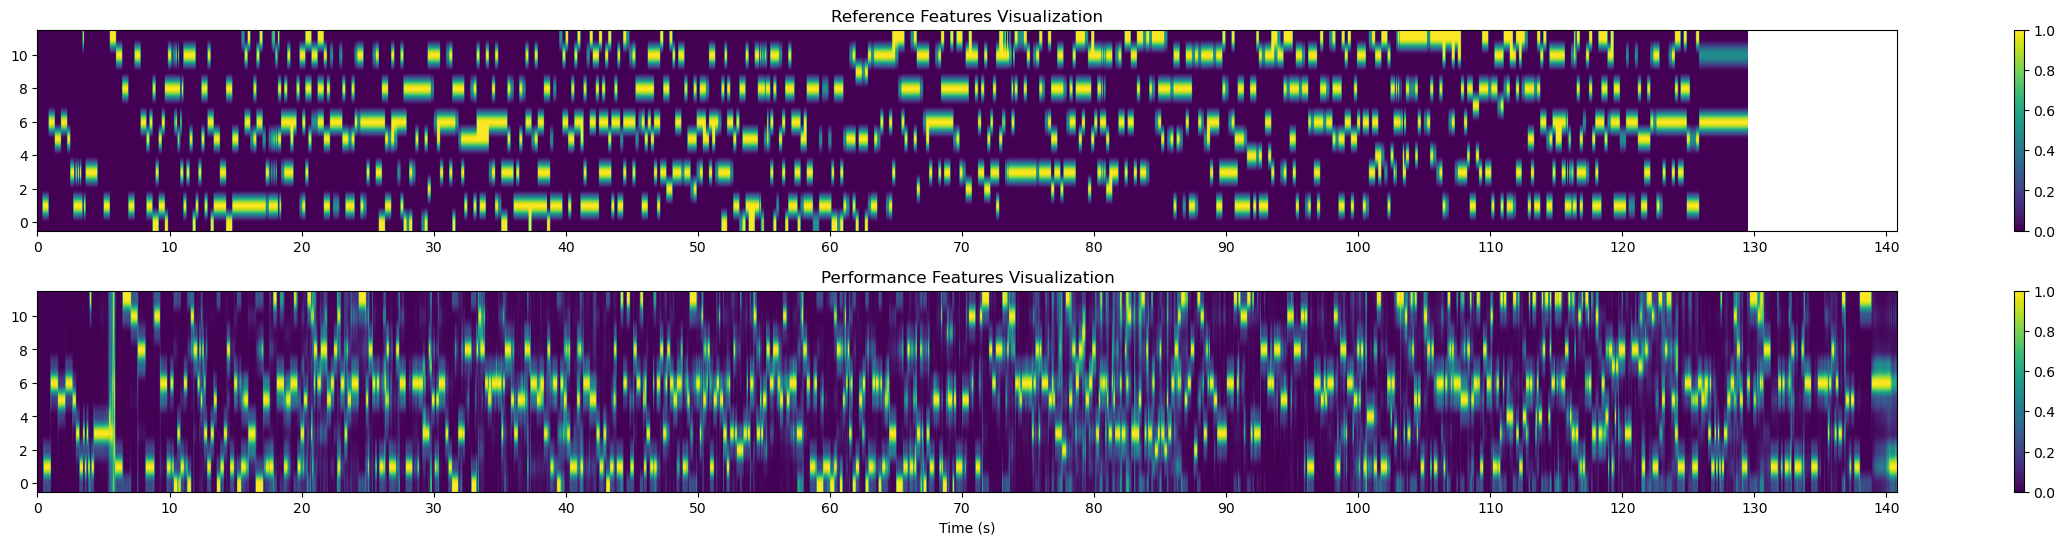

In [5]:
max_step = np.max((oltw.ref_pointer, oltw.input_pointer))
max_x_time = max_step / FRAME_RATE

x_ticks = np.arange(0, max_x_time, 10)
x_labels = [f"{x:.0f}" for x in x_ticks]

plt.figure(figsize=(30, 6))

# First subplot
plt.subplot(211)
plt.title("Reference Features Visualization")
plt.imshow(oltw.reference_features.T, aspect="auto", origin="lower")
plt.xlim(0, max_step)
plt.colorbar()
plt.xticks(ticks=x_ticks * FRAME_RATE, labels=x_labels)

# Second subplot
plt.subplot(212)
plt.title("Performance Features Visualization")
plt.imshow(oltw.input_features.T, aspect="auto", origin="lower")
plt.xlim(0, max_step)
plt.colorbar()
plt.xticks(ticks=x_ticks * FRAME_RATE, labels=x_labels)
plt.xlabel("Time (s)")

plt.subplots_adjust(hspace=0.3)
plt.show()

## Accumulated distance matrix with warping path & ground-truth labels

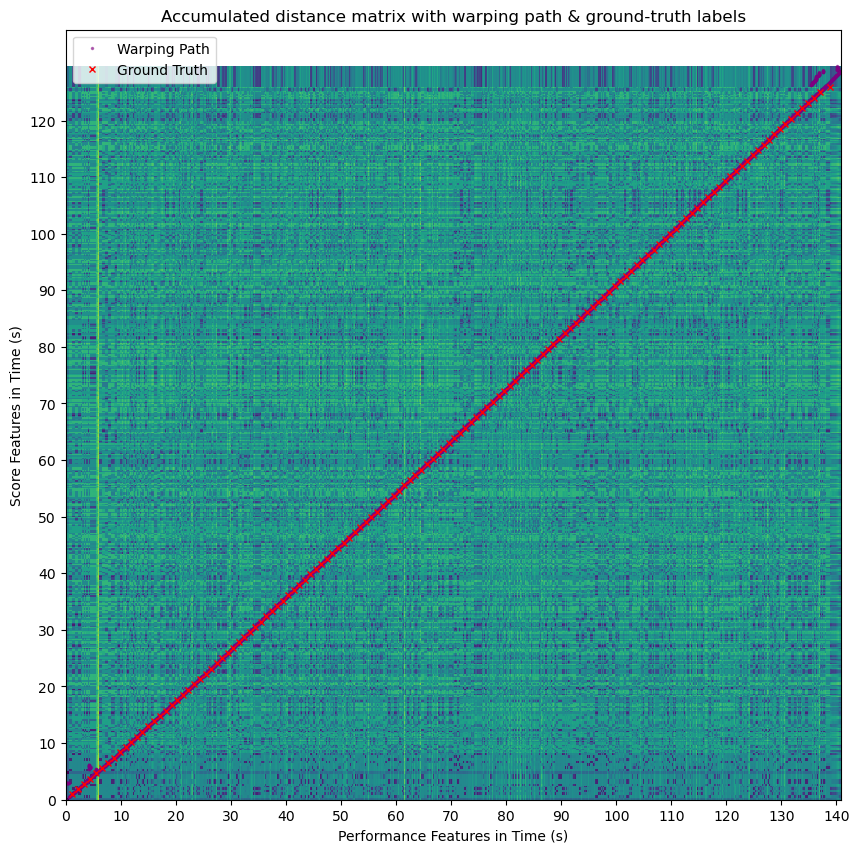

In [6]:
visualize_warping_path(oltw, score_ann, perf_ann)